# Brest cancer classifier

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import layers, models, optimizers, callbacks, metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Pre-processing

#### Gathers image paths and extracts patient IDs & labels.


In [3]:
ROOT_DIR = 'IDC_regular_ps50_idx5'

records = []
for pid in os.listdir(ROOT_DIR):
    pdir = os.path.join(ROOT_DIR, pid)
    if not os.path.isdir(pdir):
        continue
    for label in ['0', '1']:
        ldir = os.path.join(pdir, label)
        if not os.path.isdir(ldir):
            continue
        for ext in ('png', 'jpg', 'jpeg'):
            for path in glob.glob(os.path.join(ldir, f'*.{ext}')):
                records.append({'path': path,
                                'patient_id': pid,
                                'label': int(label)})

the code above traverses our data/ folder as shown in this Tree, taking the ``path`` of the 50x50 patch, the ``patient_id`` of this patch and its ``class``.

```
data/
└── IDC_regular_ps50_idx5/
    ├── 10253/
    │   ├── 0/
    │   └── 1/
    ├── 10254/
    │   ├── 0/
    │   └── 1/
    … etc.

```

In [4]:
df = pd.DataFrame(records)

df.head()

,path,patient_id,label
0,IDC_regular_ps50_idx5/8959/0/8959_idx5_x1201_y...,8959,0
1,IDC_regular_ps50_idx5/8959/0/8959_idx5_x1401_y...,8959,0
2,IDC_regular_ps50_idx5/8959/0/8959_idx5_x201_y1...,8959,0
3,IDC_regular_ps50_idx5/8959/0/8959_idx5_x901_y1...,8959,0
4,IDC_regular_ps50_idx5/8959/0/8959_idx5_x1051_y...,8959,0


#### Splits patients into train/val/test sets.



In [5]:
patients = df['patient_id'].unique()

train_p, temp_p = train_test_split(patients, test_size=0.30, random_state=42)

val_p, test_p  = train_test_split(temp_p, test_size=0.50, random_state=42)

# so here we have train_patients, val_patients, test_patients 70%, 15%, 15%



Patient‐level splits block any overlap of tissue artifacts between training and testing, ensuring the model truly generalizes to new patients—so our reported sensitivity (recall) and predictive‐value (précision) scores reflect real‐world clinical performance.

In [6]:

# Filter the original DataFrame to create each split
train_df = df[df['patient_id'].isin(train_p)].reset_index(drop=True)
val_df   = df[df['patient_id'].isin(val_p)].reset_index(drop=True)
test_df  = df[df['patient_id'].isin(test_p)].reset_index(drop=True)

print(f"Train patients: {len(train_p)}, patches: {len(train_df)}")
print(f"Val   patients: {len(val_p)}, patches: {len(val_df)}")
print(f"Test  patients: {len(test_p)}, patches: {len(test_df)}")

print(f"\ntrain_df shape = {train_df.shape}")
print(f"val_df shape = {val_df.shape}")
print(f"train_df shape = {test_df.shape}")


Train patients: 195, patches: 197063
Val   patients: 42, patches: 41368
Test  patients: 42, patches: 39093

train_df shape = (197063, 3)
val_df shape = (41368, 3)
train_df shape = (39093, 3)


Showing how much this data is imbalanced :

In [7]:
test = df["label"].mean()

print(f"malignant   : {test*100:.2f}")
print(f"benign      : {(1-test)*100:.2f}")

malignant   : 28.39
benign      : 71.61


#### Data pipeLine.

In [8]:
# --- 4. Build tf.data pipelines -----------------------------------

AUTOTUNE   = tf.data.AUTOTUNE
BATCH_SIZE = 64
IMG_SIZE   = (50, 50)

#GPU-accelerated
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1, 0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

def parse_and_preprocess(path, label, augment=False):
    """Load, decode, resize, rescale to [0,1], then optionally augment."""
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)       # float32 [0–1]
    img = tf.image.resize(img, IMG_SIZE)
    if augment:
        img = data_augmentation(img)
    return img, label

def make_dataset(df_split, shuffle=False, augment=False):
    paths  = df_split['path'].values
    labels = df_split['label'].values.astype('int32')
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(lambda p, y: parse_and_preprocess(p, y, augment),
                num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# build keras dataset
train_ds = make_dataset(train_df, shuffle=True,  augment=True)
val_ds   = make_dataset(val_df,   shuffle=False, augment=False)
test_ds  = make_dataset(test_df,  shuffle=False, augment=False)


2025-05-05 22:58:42.357094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-05 22:58:42.517144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-05 22:58:42.517198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-05 22:58:42.518796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

#### balancing classes for training.

In [9]:
y_train = train_df['label'].values  # 0 or 1

# 2. Compute balanced class weights
#    This gives higher weight to the minority class automatically.
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {int(cls): weight for cls, weight in zip(np.unique(y_train), weights)}

print("Class weights:", class_weight_dict)

Class weights: {0: 0.6958095291899412, 1: 1.7767509376803232}


## Visualisation

#### Let's just start by EyeBalling the images

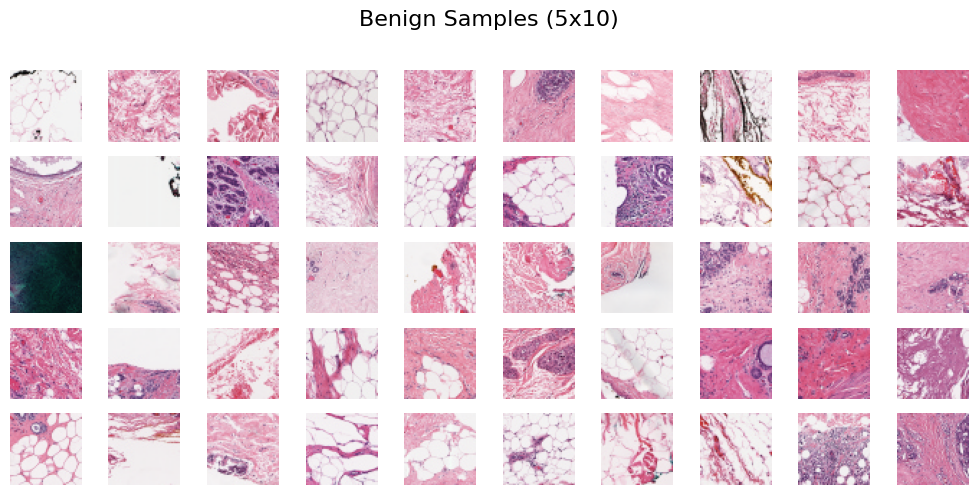

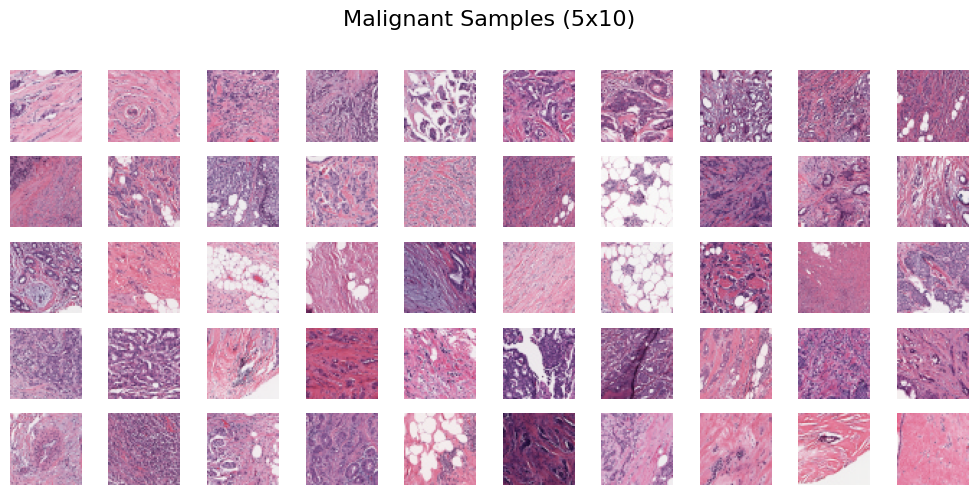

In [10]:
import random
from PIL import Image

# Function to plot a montage of images
def plot_montage(paths, title, rows=5, cols=10):
    n = rows * cols
    sampled_paths = random.sample(paths, min(len(paths), n))
    
    plt.figure(figsize=(cols, rows))
    plt.suptitle(title, fontsize=16)
    
    for i, p in enumerate(sampled_paths):
        ax = plt.subplot(rows, cols, i + 1)
        img = Image.open(p)
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Prepare paths for each class
benign_paths    = df[df['label'] == 0]['path'].tolist()
malignant_paths = df[df['label'] == 1]['path'].tolist()

# Plot montages
plot_montage(benign_paths,    "Benign Samples (5x10)",    rows=5, cols=10)
plot_montage(malignant_paths, "Malignant Samples (5x10)", rows=5, cols=10)

Color : We notice that the malignant samples are darker than the other class, so to make sur of this hypothesis, let's see the distribution of the RGB colors for both classes. (Color-channel histograms).

Tissue architecture : In the benign grid you see broad, open spaces white bubbles, however the malignant class shows elements that are more crowded with fewer open spaces.

#### Color‐channel histograms

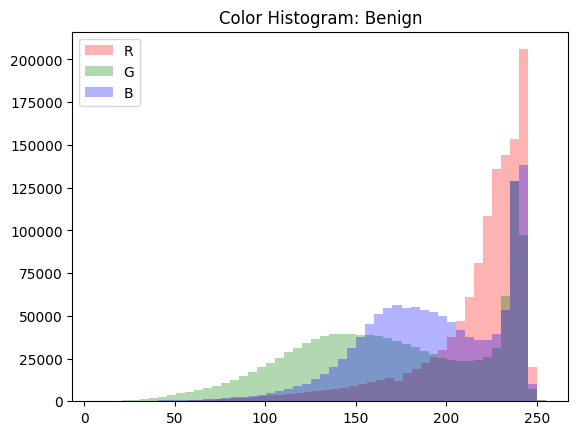

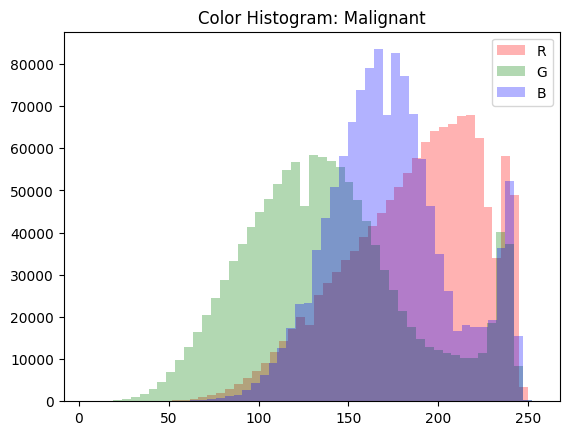

In [11]:
def plot_color_hist(paths, title, n=500):
    samples = random.sample(paths, min(len(paths), n))
    pixels = np.vstack([np.array(Image.open(p)).reshape(-1,3) for p in samples])
    colors = ('r','g','b')
    plt.figure()
    for i, col in enumerate(colors):
        plt.hist(pixels[:,i], bins=50, alpha=0.3, color=col, label=col.upper())
    plt.title(title)
    plt.legend()
    plt.show()

plot_color_hist(benign_paths,    "Color Histogram: Benign")
plot_color_hist(malignant_paths, "Color Histogram: Malignant")

The histogram confirms what we said.

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.manifold import TSNE
import seaborn as sns

# 1) Load model & pick random subset
base = ResNet50(weights='imagenet', include_top=False, pooling='avg')
subset = df.sample(15000, random_state=42).reset_index(drop=True)

# 2) Preprocess & extract
def extract_feats(paths):
    imgs = [np.array(Image.open(p).resize((224,224))) for p in paths]
    x = preprocess_input(np.stack(imgs))
    return base.predict(x, verbose=0)

feats = extract_feats(subset['path'])

: 

In [20]:
from sklearn.manifold import TSNE
from PIL import Image
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
# 2) Preprocess & extract
subset = df.sample(15000, random_state=42).reset_index(drop=True)
def extract_feats(paths):
    imgs = [np.array(Image.open(p).resize((224,224))) for p in paths]
    x = preprocess_input(np.stack(imgs))
    return base.predict(x, verbose=0)

feats = extract_feats(subset['path'])

: 

In [16]:
# T-sne

tsne = TSNE(n_components=2, random_state=42)
emb  = tsne.fit_transform(feats)

subset['label_str'] = subset['label'].map({0: 'Benign', 1: 'Malignant'})
palette = {'Benign': 'blue', 'Malignant': 'red'}

plt.figure(figsize=(16,12))
sns.scatterplot(
    x=emb[:,0], y=emb[:,1],
    hue=subset['label_str'],
    palette=palette,
    alpha=0.6
)
plt.title("t-SNE of CNN Features")
plt.legend(title="Class")
plt.show()


NameError: name 'feats' is not defined

The t-SNE shows that malignant patches (red) tend to occupy a distinct region from benign (blue), which is exactly what our “filter out benign” tool needs—clear feature separation so we can choose a threshold that safely weeds out most benign tiles. The overlap zone in the middle pinpoints the “uncertain” patches where the model is less confident.

## Modeling

In [12]:
def build_cnn(input_shape=(*IMG_SIZE,3), base_filters=32, dropout_rate=0.5):
    model = models.Sequential([
        layers.Input(input_shape),
        # Block 1
        layers.Conv2D(base_filters, (3,3), activation='relu', padding='same'),
        layers.Conv2D(base_filters, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(dropout_rate/2),
        # Block 2
        layers.Conv2D(base_filters*2, (3,3), activation='relu', padding='same'),
        layers.Conv2D(base_filters*2, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(dropout_rate),
        # Block 3
        layers.Conv2D(base_filters*4, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(dropout_rate),
        # Head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ], name="IDC_CNN")
    return model

model = build_cnn()
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=[
        metrics.Recall(name='recall'),
        metrics.Precision(name='precision'),
        metrics.AUC(name='auc'),
        metrics.AUC(name='pr_auc', curve='PR')
    ]
)
model.summary()

Model: "IDC_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 64)        36928     
                                                           

In [13]:
# --- 6. Callbacks & Training ------------------------------------------------

cb = [
    callbacks.ReduceLROnPlateau(monitor='val_recall', mode='max',
                                factor=0.5, patience=3, verbose=1),
    callbacks.EarlyStopping(monitor='val_recall', mode='max',
                            patience=6, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=cb
)

# --- 7. Evaluation -----------------------------------------------------------

print("\nEvaluating on test set:")
results = model.evaluate(test_ds)
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

Epoch 1/15


2025-05-05 22:59:07.745216: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2025-05-05 22:59:08.842980: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3080/3080 [==============================] - 253s 81ms/step - loss: 0.4634 - recall: 0.7541 - precision: 0.6112 - auc: 0.8629 - pr_auc: 0.7159 - val_loss: 0.7213 - val_recall: 0.9535 - val_precision: 0.3724 - val_auc: 0.8847 - val_pr_auc: 0.7048 - lr: 1.0000e-04
Epoch 2/15
3080/3080 [==============================] - 247s 80ms/step - loss: 0.4130 - recall: 0.8260 - precision: 0.6330 - auc: 0.8930 - pr_auc: 0.7664 - val_loss: 0.7303 - val_recall: 0.9566 - val_precision: 0.3793 - val_auc: 0.8804 - val_pr_auc: 0.6667 - lr: 1.0000e-04
Epoch 3/15
3080/3080 [==============================] - 267s 87ms/step - loss: 0.3943 - recall: 0.8396 - precision: 0.6464 - auc: 0.9029 - pr_auc: 0.7815 - val_loss: 0.7639 - val_recall: 0.9697 - val_precision: 0.3638 - val_auc: 0.8833 - val_pr_auc: 0.6608 - lr: 1.0000e-04
Epoch 4/15
 687/3080 [=====>........................] - ETA: 3:12 - loss: 0.3865 - recall: 0.8463 - precision: 0.6491 - auc: 0.9068 - pr_auc: 0.7906

KeyboardInterrupt: 

- Recall = 0.969 confirms the model flags 96.9 % of malignant patches—nearly every cancerous tile is caught, minimizing the risk of missed diagnoses.

- Precision = 0.368 tells us that about 37 % of patches presented to the doctor are actually malignant, reducing their benign workload by over 60 %.

In practice, this means this model can safely filter out the majority of benign images (low false negatives) while still cutting down the number of tiles a doctor must review. A slight adjustment of the decision threshold could push recall even closer to 100 %.

In [ ]:
#validation et auc
#pq on a choisi un dropout de 20%

# Courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss par époque')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()

# Courbe de précision (si disponible)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy par époque')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # diagonale
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, recall_score, precision_score

# we gather all true labels and predicted scores
y_true = []
y_scores = []
for imgs, labs in val_ds:
    y_true.append(labs.numpy())
    y_scores.append(model.predict(imgs).ravel())
y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

# Compute precision & recall at all thresholds
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

# Find the lowest threshold that gives recall >= target_recall
target_recall = 0.99
valid_idxs = np.where(recalls[:-1] >= target_recall)[0]
if len(valid_idxs)==0:
    print(f"No threshold achieves recall ≥ {target_recall}")
else:
    # pick the threshold with highest precision among those
    best_idx = valid_idxs[np.argmax(precisions[valid_idxs])]
    best_thresh = thresholds[best_idx]
    best_prec  = precisions[best_idx]
    best_rec   = recalls[best_idx]
    print(f"Chosen threshold: {best_thresh:.4f}")
    print(f"  Recall @ this thresh:    {best_rec:.3f}")
    print(f"  Precision @ this thresh: {best_prec:.3f}")

    y_pred = (y_scores >= best_thresh).astype(int)
    print("\nValidation metrics at tuned threshold:")
    print("  Recall:   ", recall_score(y_true, y_pred))
    print("  Precision:", precision_score(y_true, y_pred))
    print("best thresh:", best_thresh)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━

2025-05-05 07:23:19.530002: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


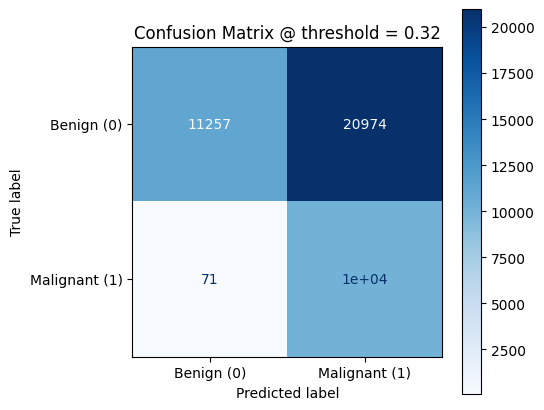

True Negatives (benign correctly filtered out): 11257
False Positives (benign flagged as malignant):   20974
False Negatives (malignant missed):            71
True Positives (malignant correctly flagged):  10080


In [ ]:


y_true = []
y_scores = []
for imgs, labs in test_ds:
    y_true.append(labs.numpy())
    y_scores.append(model.predict(imgs).ravel())
y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

# Binarize predictions the new threshold
y_pred = (y_scores >= best_thresh).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Benign (0)', 'Malignant (1)']
)

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues')
plt.title(f'Confusion Matrix @ threshold = {best_thresh:.2f}')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (benign correctly filtered out): {tn}")
print(f"False Positives (benign flagged as malignant):   {fp}")
print(f"False Negatives (malignant missed):            {fn}")
print(f"True Positives (malignant correctly flagged):  {tp}")

This confusion matrix tells a clear story:

- True Negatives (TN) = 11 257
    - we are correctly filtered out about 11 k benign patches these the doctor never has to look at.

- False Positives (FP) = 20 974
    - Roughly 21 k benign patches still slip through for review.

- False Negatives (FN) = 71 (very good)
    - we missed only 71 malignant patches out of about 10 151 total—that’s a recall of 99.3 %, which is excellent for a safety‐critical triage tool.

- rue Positives (TP) = 10 080
    - we caught almost all of the cancers (≈ 10 k patches).

From a “don’t miss any cancers” standpoint, we’ve almost eliminated false negatives. 

Precision is modest (≈ 1/3), meaning the doctor will still review many benign patches, but that’s the trade-off to hit the 99 %+ recall target.

We prefer to have more False Positives but having more True Positives than having more True Negatives and having False Negatives (we will miss a lot of malignant tumors)

Note: We only kept the best models that we had

HASHEMI Seyedali, CHAHBAOUI Mohammed, KARATAS Musab